# GAMMA Challenge Subtask 3 - Optic Disc and Cup Segmentation - Marco

In [ ]:
!pwd

/home/aistudio


In [ ]:
!unzip -o /home/aistudio/data/data100624/GAMMA_training_data.zip  -d /home/aistudio/

In [ ]:
!mv -u data/train_data2/training_data /home/aistudio/

In [ ]:
### remove the extraneous files in the data folder

!rm */.DS_Store
!rm */*/.DS_Store
!rm */*/*/.DS_Store

rm: cannot remove '*/.DS_Store': No such file or directory
rm: cannot remove '*/*/.DS_Store': No such file or directory


In [ ]:
!pip install paddleseg

In [2]:
### import the necessary packages

import sys 
sys.path.append('/home/aistudio/external-libraries')
import os
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances 
import matplotlib.pylab as plt

import paddle
import paddle.nn as nn
from paddle.io import Dataset
import paddle.nn.functional as F   # cannot replaced by import functional as F
import paddle.vision.transforms as trans
# import transforms as trans 



### Config

In [3]:
### set the parameters in your framework

images_file = 'training_data/multi-modality_images'  # the path to the training data
gt_file = 'training_data/Disc_Cup_Mask/'
test_file = ''  # the path to the testing data
val_ratio = 0.1  # the ratio of train/validation splitition
image_size = 512 # the image size to the network (image_size, image_size, 3) 256
BATCH_SIZE = 8 # batch size
iters = 20000 # training iteration
optimizer_type = 'adam' # the optimizer, can be set as SGD, RMSprop,...
num_workers = 8 # Number of workers used to load data
init_lr = 1e-3 # the initial learning rate


### Train / Val splitition


In [4]:
### divide the training image and the verification image from the training set 

filelists = os.listdir(images_file)
filelists.sort()
random.seed()
train_filelists, val_filelists = train_test_split(filelists, test_size = val_ratio,random_state = 42) # random_state = int(random.random()*100) is absolutely random
print("Total Nums: {}, train: {}, val: {}".format(len(filelists), len(train_filelists), len(val_filelists)))
# print(filelists)
print(val_filelists)
print(train_filelists)

Total Nums: 100, train: 90, val: 10
['0084', '0054', '0071', '0046', '0045', '0040', '0023', '0081', '0011', '0001']
['0019', '0031', '0074', '0034', '0091', '0005', '0077', '0078', '0013', '0032', '0056', '0089', '0027', '0043', '0070', '0016', '0041', '0097', '0010', '0073', '0012', '0048', '0086', '0029', '0094', '0006', '0067', '0066', '0036', '0017', '0050', '0035', '0008', '0096', '0028', '0020', '0082', '0026', '0063', '0014', '0025', '0004', '0018', '0039', '0009', '0079', '0007', '0065', '0037', '0090', '0057', '0100', '0055', '0044', '0051', '0068', '0047', '0069', '0062', '0098', '0080', '0042', '0059', '0049', '0099', '0058', '0076', '0033', '0095', '0060', '0064', '0085', '0038', '0030', '0002', '0053', '0022', '0003', '0024', '0088', '0092', '0075', '0087', '0083', '0021', '0061', '0072', '0015', '0093', '0052']


### DataLoader

In [5]:
### load the fundus images from the data folder, Marco's Version
### and extract the corresponding ground truth to generate training samples

class FundusDataset(Dataset):
    def __init__(self, image_file, gt_path=None, fundus_transforms=None, color_jitter=False, filelists=None,  mode='train'):
        super(FundusDataset, self).__init__()
        self.fundus_transforms = fundus_transforms
        self.color_jitter = color_jitter
        self.mode = mode
        self.image_path = image_file
        image_idxs = os.listdir(self.image_path) # 0001, fundus_img in the folder 0001
        self.gt_path = gt_path

        self.file_list = [image_idxs[i] for i in range(len(image_idxs))]        
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item in filelists] 
   
    def __getitem__(self, idx):
        real_index = self.file_list[idx]
        fundus_img_path = os.path.join(self.image_path, real_index, real_index + '.jpg')
        fundus_img = cv2.imread(fundus_img_path)[:, :, ::-1] # BGR -> RGB        
        h,w,c = fundus_img.shape

        if self.mode == 'train':
            gt_tmp_path = os.path.join(self.gt_path, real_index + '.png')
            gt_img = cv2.imread(gt_tmp_path)

            ### In the ground truth, a pixel value of 0 is the optic cup (class 0), 
            ### a pixel value of 128 is the optic disc (class 1), 
            ### and a pixel value of 255 is the background (class 2).
            
            gt_img[gt_img == 128] = 1
            gt_img[gt_img == 255] = 2
            gt_img[gt_img == 0] = 3
            # Crop Center Square
            gt_img_h, gt_img_w = gt_img.shape[:2]
            gh, gw = min(gt_img_h, gt_img_w), min(gt_img_h, gt_img_w)
            gt_img = trans.center_crop(gt_img, (gh, gw)) # for paddle.vision.transforms
            # CenterCrop = trans.CenterCrop((gh, gw)) # for self-defined transforms.py
            # gt_img = CenterCrop(gt_img)

            gt_img = cv2.resize(gt_img,(image_size, image_size))
            # if self.fundus_transforms is not None:
            #     gt_img = self.fundus_transforms(gt_img)
            gt_img = gt_img[:,:,1]
            # print('gt shape', gt_img.shape)           
        
        # Crop Center Square
        fundus_img_h, fundus_img_w = fundus_img.shape[:2]
        fh, fw = min(fundus_img_h, fundus_img_w), min(fundus_img_h, fundus_img_w)
        fundus_img = trans.center_crop(fundus_img, (fh, fw)) # for paddle.vision.transforms
        # CenterCrop = trans.CenterCrop((fh, fw)) # for self-defined transforms.py
        # fundus_img = CenterCrop(fundus_img)

        fundus_img = cv2.resize(fundus_img,(image_size, image_size))
        # if self.fundus_transforms is not None:
        #     fundus_img = self.fundus_transforms(fundus_img)
        
        if self.fundus_transforms is not None:
            img4 = cv2.merge([fundus_img, gt_img])
            img4 = self.fundus_transforms(img4)
            fundus_img = img4[:,:,0:3]
            if self.color_jitter == True: 
                color_jitter= trans.ColorJitter(0.05, 0.05, 0.05, 0.05)  # color jitter fundus images, while keep labels
                fundus_img=color_jitter(fundus_img)

            gt_img = img4[:,:,3]

            gt_img[gt_img == 0] = 2
            gt_img[gt_img == 3] = 0

        fundus_img = fundus_img.transpose(2, 0, 1) # H, W, C -> C, H, W
        # print(img.shape)
        # img = fundus_img.astype(np.float32)
        
        if self.mode == 'test':
            ### During the testing process, 
            ### the sample returns fundus image, sample name, 
            ### height and width of the original image

            return fundus_img, real_index, h, w
        if self.mode == 'train':
            ### During the training process,
            ### the sample returns fundus image and its corresponding ground truth
            
            return fundus_img, gt_img

    def __len__(self):
        return len(self.file_list)


In [ ]:
### generate a _train and a _val Dataset for presenting images in the training dataset

img_train_transforms = trans.Compose([
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip(),
    trans.RandomRotation(60),
    # trans.ColorJitter(0.2, 0.2, 0.2, 0.05)
])
img_val_transforms = trans.Compose([ ])

#trans.RandomResizedCrop(image_size, scale=(1.0, 1.0), ratio=(1.0, 1.0)),

_train = FundusDataset(image_file = images_file, 
                       fundus_transforms = img_train_transforms,
                       color_jitter = True,
                       gt_path = gt_file)

_val = FundusDataset(image_file = images_file, 
                     fundus_transforms = img_val_transforms,
                     gt_path = gt_file)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

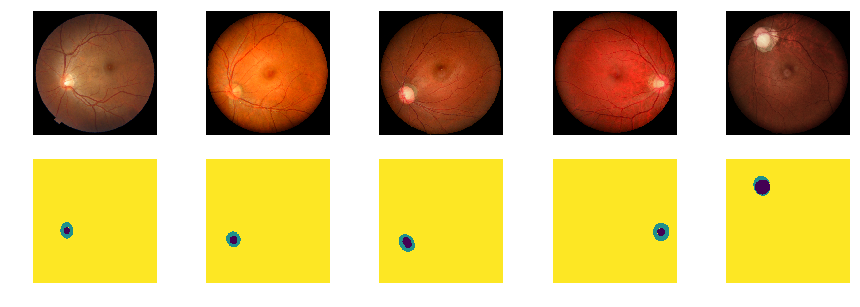

In [ ]:
### present five fundus images and corresponding ground truths in the _train Dataset
### there are three classes in the ground truth: 0-optic cup, 1-optic disc, 2-background

plt.figure(figsize=(15,5))

for i in range(5):
    fundus_img, label = _train.__getitem__(i)
    plt.subplot(2,5,i+1)
    plt.imshow(fundus_img.transpose(1,2,0))
    plt.axis("off")

    plt.subplot(2,5,i+6)
    plt.imshow(label)
    plt.axis("off")

    

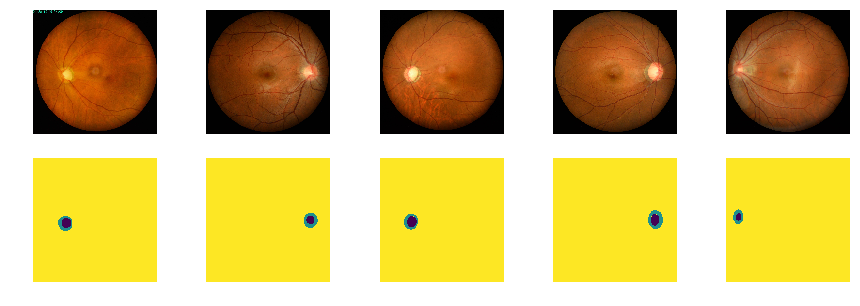

In [ ]:
### present five fundus images and corresponding ground truths in the _val Dataset

plt.figure(figsize=(15,5))

for i in range(5):
    fundus_img, label = _val.__getitem__(i)
    plt.subplot(2,5,i+1)
    plt.imshow(fundus_img.transpose(1,2,0))
    plt.axis("off")

    plt.subplot(2,5,i+6)
    plt.imshow(label)
    plt.axis("off")

   

In [ ]:
img=cv2.merge([fundus_img, label])
img.shape
fundus_img = img[:,:,0:3]
label = img[:,:,3]
print(fundus_img.shape, label.shape)
plt.imshow(fundus_img)

(256, 256, 4)

### Network

This network is UNet.
U-NET is a U-shaped network structure, which can be seen as two large stages. The image is first sampled by the Encoder to obtain the high-level semantic feature map, and then sampled by the Decoder to restore the feature map to the resolution of the original image.
The details of the codes can be seen at https://www.paddlepaddle.org.cn/documentation/docs/zh/tutorial/cv_case/image_segmentation/image_segmentation.html

In [ ]:
class SeparableConv2D(nn.Layer):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride=1, 
                 padding=0, 
                 dilation=1, 
                 groups=None, 
                 weight_attr=None, 
                 bias_attr=None, 
                 data_format="NCHW"):
        super(SeparableConv2D, self).__init__()

        self._padding = padding
        self._stride = stride
        self._dilation = dilation
        self._in_channels = in_channels
        self._data_format = data_format

        # 第一次卷积参数，没有偏置参数
        filter_shape = [in_channels, 1] + self.convert_to_list(kernel_size, 2, 'kernel_size')
        self.weight_conv = self.create_parameter(shape=filter_shape, attr=weight_attr)

        # 第二次卷积参数
        filter_shape = [out_channels, in_channels] + self.convert_to_list(1, 2, 'kernel_size')
        self.weight_pointwise = self.create_parameter(shape=filter_shape, attr=weight_attr)
        self.bias_pointwise = self.create_parameter(shape=[out_channels], 
                                                    attr=bias_attr, 
                                                    is_bias=True)
    
    def convert_to_list(self, value, n, name, dtype=np.int):
        if isinstance(value, dtype):
            return [value, ] * n
        else:
            try:
                value_list = list(value)
            except TypeError:
                raise ValueError("The " + name +
                                "'s type must be list or tuple. Received: " + str(
                                    value))
            if len(value_list) != n:
                raise ValueError("The " + name + "'s length must be " + str(n) +
                                ". Received: " + str(value))
            for single_value in value_list:
                try:
                    dtype(single_value)
                except (ValueError, TypeError):
                    raise ValueError(
                        "The " + name + "'s type must be a list or tuple of " + str(
                            n) + " " + str(dtype) + " . Received: " + str(
                                value) + " "
                        "including element " + str(single_value) + " of type" + " "
                        + str(type(single_value)))
            return value_list
    
    def forward(self, inputs):
        conv_out = F.conv2d(inputs, 
                            self.weight_conv, 
                            padding=self._padding,
                            stride=self._stride,
                            dilation=self._dilation,
                            groups=self._in_channels,
                            data_format=self._data_format)
        
        out = F.conv2d(conv_out,
                       self.weight_pointwise,
                       bias=self.bias_pointwise,
                       padding=0,
                       stride=1,
                       dilation=1,
                       groups=1,
                       data_format=self._data_format)

        return out


In [ ]:
class Encoder(nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        
        self.relus = nn.LayerList(
            [nn.ReLU() for i in range(2)])
        self.separable_conv_01 = SeparableConv2D(in_channels, 
                                                 out_channels, 
                                                 kernel_size=3, 
                                                 padding='same')
        self.bns = nn.LayerList(
            [nn.BatchNorm2D(out_channels) for i in range(2)])
        
        self.separable_conv_02 = SeparableConv2D(out_channels, 
                                                 out_channels, 
                                                 kernel_size=3, 
                                                 padding='same')
        self.pool = nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.residual_conv = nn.Conv2D(in_channels, 
                                        out_channels, 
                                        kernel_size=1, 
                                        stride=2, 
                                        padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs
        
        y = self.relus[0](inputs)
        y = self.separable_conv_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.separable_conv_02(y)
        y = self.bns[1](y)
        y = self.pool(y)
        
        residual = self.residual_conv(previous_block_activation)
        y = paddle.add(y, residual)

        return y


In [ ]:
class Decoder(nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.relus = nn.LayerList(
            [nn.ReLU() for i in range(2)])
        self.conv_transpose_01 = nn.Conv2DTranspose(in_channels, 
                                                           out_channels, 
                                                           kernel_size=3, 
                                                           padding=1)
        self.conv_transpose_02 = nn.Conv2DTranspose(out_channels, 
                                                           out_channels, 
                                                           kernel_size=3, 
                                                           padding=1)
        self.bns = nn.LayerList(
            [nn.BatchNorm2D(out_channels) for i in range(2)]
        )
        self.upsamples = nn.LayerList(
            [nn.Upsample(scale_factor=2.0) for i in range(2)]
        )
        self.residual_conv = nn.Conv2D(in_channels, 
                                        out_channels, 
                                        kernel_size=1, 
                                        padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        y = self.relus[0](inputs)
        y = self.conv_transpose_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.conv_transpose_02(y)
        y = self.bns[1](y)
        y = self.upsamples[0](y)
        
        residual = self.upsamples[1](previous_block_activation)
        residual = self.residual_conv(residual)
        
        y = paddle.add(y, residual)
        
        return y


In [ ]:
class cup_disc_UNet(nn.Layer):
    def __init__(self, num_classes):
        super(cup_disc_UNet, self).__init__()

        self.conv_1 = nn.Conv2D(3, 32, 
                                kernel_size=3,
                                stride=2,
                                padding='same')
        self.bn = nn.BatchNorm2D(32)
        self.relu = nn.ReLU()

        in_channels = 32
        self.encoders = []
        self.encoder_list = [64, 128, 256]
        self.decoder_list = [256, 128, 64, 32]

        # 根据下采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.encoder_list:
            block = self.add_sublayer('encoder_{}'.format(out_channels),
                                      Encoder(in_channels, out_channels))
            self.encoders.append(block)
            in_channels = out_channels

        self.decoders = []

        # 根据上采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.decoder_list:
            block = self.add_sublayer('decoder_{}'.format(out_channels), 
                                      Decoder(in_channels, out_channels))
            self.decoders.append(block)
            in_channels = out_channels

        self.output_conv = nn.Conv2D(in_channels, 
                                            num_classes, 
                                            kernel_size=3, 
                                            padding='same')
    
    def forward(self, inputs):
        y = self.conv_1(inputs)
        y = self.bn(y)
        y = self.relu(y)
        
        for encoder in self.encoders:
            y = encoder(y)

        for decoder in self.decoders:
            y = decoder(y)
        
        y = self.output_conv(y)
        return y


GR-ConvNet

### Utils

In [6]:
### Loss == Dice, DiceLoss is a metric function (Baseline)
### with softmax processing of logits 
### we use DICE metric to validate the predicted results 
### The detailed introduction of DICE coefficient 
### can be found at https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
### DiceLoss 1 number_class = 3

class DiceLoss(nn.Layer):
    """
    Implements the dice loss function.
    Args:
        ignore_index (int64): Specifies a target value that is ignored
            and does not contribute to the input gradient. Default ``255``.
    """

    def __init__(self, ignore_index=2):
        super(DiceLoss, self).__init__()
        self.ignore_index = ignore_index
        self.eps = 1e-5

    def forward(self, logits, labels):  # logits.shape=[1,3,256,256], labels.shape =[1,256,256]
        if len(labels.shape) != len(logits.shape):
            labels = paddle.unsqueeze(labels, 1) # from[1,256,256] to [1,1,256,256]
        num_classes = logits.shape[1]  # 3
        mask = (labels != self.ignore_index)
        logits = logits * mask  # ignore background pixels
        labels = paddle.cast(labels, dtype='int32')  # dtype tensor 
        single_label_lists = []
        for c in range(num_classes):    # transfer the single-channel label into 3-channel label
            single_label = paddle.cast((labels == c), dtype='int32') # labels =0,1,2
            single_label = paddle.squeeze(single_label, axis=1) # from [1,1,256,256]， [1,256,256]
            single_label_lists.append(single_label)
        labels_one_hot = paddle.stack(tuple(single_label_lists), axis=1)  # label [1,3,256,256] 
        logits = F.softmax(logits, axis=1)
        labels_one_hot = paddle.cast(labels_one_hot, dtype='float32')
        dims = (0,) + tuple(range(2, labels.ndimension()))
        intersection = paddle.sum(logits * labels_one_hot, dims)
        cardinality = paddle.sum(logits, dims) + paddle.sum(labels_one_hot, dims) 
        dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
        return dice_loss

In [7]:
### Loss == Dice, MinusDiceLoss is a loss function
### with softmax processing of logits 
### we use DICE metric to validate the predicted results 
### The detailed introduction of DICE coefficient 
### can be found at https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
### DiceLoss 1 number_class = 3

class MinusDiceLoss(nn.Layer):
    """
    Implements the dice loss function.
    Args:
        ignore_index (int64): Specifies a target value that is ignored
            and does not contribute to the input gradient. Default ``255``.
    """

    def __init__(self, ignore_index=2):
        super(MinusDiceLoss, self).__init__()
        self.ignore_index = ignore_index
        self.eps = 1e-5

    def forward(self, logits, labels):  # logits.shape=[1,3,256,256], labels.shape =[1,256,256]
        if len(labels.shape) != len(logits.shape):
            labels = paddle.unsqueeze(labels, 1) # from[1,256,256] to [1,1,256,256]
        num_classes = logits.shape[1]  # 3
        mask = (labels != self.ignore_index)
        logits = logits * mask
        labels = paddle.cast(labels, dtype='int32')  # dtype tensor 
        single_label_lists = []
        for c in range(num_classes):    # transfer the single-channel label into 3-channel label
            single_label = paddle.cast((labels == c), dtype='int32') # labels =0,1,2
            single_label = paddle.squeeze(single_label, axis=1) # from [1,1,256,256]， [1,256,256]
            single_label_lists.append(single_label)
        labels_one_hot = paddle.stack(tuple(single_label_lists), axis=1)  # label [1,3,256,256] 
        logits = F.softmax(logits, axis=1)
        labels_one_hot = paddle.cast(labels_one_hot, dtype='float32')
        dims = (0,) + tuple(range(2, labels.ndimension()))
        intersection = paddle.sum(logits * labels_one_hot, dims)
        cardinality = paddle.sum(logits, dims) + paddle.sum(labels_one_hot, dims) 
        dice_loss =1- (2. * intersection / (cardinality + self.eps)).mean()
        return dice_loss

In [9]:
# num_classes ==2 Loss == Dice, MinusDiceLoss2 is a loss function
# without softmax processing of logits 
class MinusDiceLoss2(nn.Layer):
    """
    Implements the dice loss function.
    Args:
        ignore_index (int64): Specifies a target value that is ignored
            and does not contribute to the input gradient. Default ``255``.
    """

    def __init__(self, ignore_index=2):
        super(MinusDiceLoss2, self).__init__()
        self.ignore_index = ignore_index
        self.eps = 1e-5

    def forward(self, logits, labels):  # logits.shape=[1,3,256,256], labels.shape =[1,256,256]
        if len(labels.shape) != len(logits.shape):
            labels = paddle.unsqueeze(labels, 1) # from[1,256,256] to [1,1,256,256]
        num_classes = logits.shape[1]  # 3
        # mask = (labels != self.ignore_index)
        # logits = logits * mask  # ignore background pixels
        # mask = (logits[0][2] == 0)
        # logits = logits * mask
        logits = logits.argmax(1)

        single_logits_lists=[]
        for c in range(num_classes):
            single_logits = paddle.cast((logits == c), dtype='int32') # labels =0,1,2
            single_logits = paddle.squeeze(single_logits, axis=1) # from [1,1,256,256] to [1,256,256]
            single_logits_lists.append(single_logits)
        logits_one_hot =  paddle.stack(tuple(single_logits_lists), axis=1)
        logits_one_hot =  paddle.cast(logits_one_hot, dtype='float32')
        
        labels = paddle.cast(labels, dtype='int32')  # dtype tensor 
        single_label_lists = []
        for c in range(num_classes):    # transfer the single-channel label into 3-channel label
            single_label = paddle.cast((labels == c), dtype='int32') # labels =0,1,2
            single_label = paddle.squeeze(single_label, axis=1) # from [1,1,256,256]， [1,256,256]
            single_label_lists.append(single_label)
        labels_one_hot = paddle.stack(tuple(single_label_lists), axis=1)  # label [1,2,256,256] 
        # logits = F.softmax(logits, axis=1)
        labels_one_hot = paddle.cast(labels_one_hot, dtype='float32')

        dims = (0,) + tuple(range(2, labels.ndimension()))  # (0, 2, 3)
        # sum (0,2,3) axis , keep the 2nd dimension, which has 3 channels

        intersection = paddle.sum(logits_one_hot * labels_one_hot, dims) # 
        cardinality = paddle.sum(logits_one_hot, dims) + paddle.sum(labels_one_hot, dims)
        dice_cup =  2. * intersection[0] / (cardinality[0] + self.eps)
        dice_disc=  2. * intersection[1] / (cardinality[1] + self.eps)
        dice_background = 2. * intersection[2] / (cardinality[2] + self.eps)
        dice_loss = 1 - (0.3*dice_cup +0.42*dice_disc + 0.28*dice_background)
        # dice_loss =1- (2. * intersection / (cardinality + self.eps)).mean()
        return dice_loss

In [10]:
# num_classes ==2 Loss == Dice, Diceloss2 is a metric funtion
# without softmax processing of logits 
class DiceLoss2(nn.Layer):
    """
    Implements the dice loss function.
    Args:
        ignore_index (int64): Specifies a target value that is ignored
            and does not contribute to the input gradient. Default ``255``.
    """

    def __init__(self, ignore_index=2):
        super(DiceLoss2, self).__init__()
        self.ignore_index = ignore_index
        self.eps = 1e-5

    def forward(self, logits, labels):  # logits.shape=[1,3,256,256], labels.shape =[1,256,256]
        if len(labels.shape) != len(logits.shape):
            labels = paddle.unsqueeze(labels, 1) # from[1,256,256] to [1,1,256,256]
        num_classes = logits.shape[1]  # 3
        # mask = (labels != self.ignore_index)
        # logits = logits * mask
        # mask = (logits[0][2] == 0)
        # logits = logits * mask

        logits = logits.argmax(1)

        single_logits_lists=[]
        for c in range(num_classes):
            single_logits = paddle.cast((logits == c), dtype='int32') # labels =0,1,2
            single_logits = paddle.squeeze(single_logits, axis=1) # from [1,1,256,256] to [1,256,256]
            single_logits_lists.append(single_logits)
        logits_one_hot =  paddle.stack(tuple(single_logits_lists), axis=1)
        logits_one_hot =  paddle.cast(logits_one_hot, dtype='float32')
        
        labels = paddle.cast(labels, dtype='int32')  # dtype tensor 
        single_label_lists = []
        for c in range(num_classes):    # transfer the single-channel label into 3-channel label
            single_label = paddle.cast((labels == c), dtype='int32') # labels =0,1,2
            single_label = paddle.squeeze(single_label, axis=1) # from [1,1,256,256]， [1,256,256]
            single_label_lists.append(single_label)
        labels_one_hot = paddle.stack(tuple(single_label_lists), axis=1)  # label [1,2,256,256] 
        # logits = F.softmax(logits, axis=1)
        labels_one_hot = paddle.cast(labels_one_hot, dtype='float32')

        dims = (0,) + tuple(range(2, labels.ndimension()))  # (0, 2, 3)
        # sum (0,2,3) axis , keep the 2nd dimension, which has 3 channels

        intersection = paddle.sum(logits_one_hot * labels_one_hot, dims) # 
        cardinality = paddle.sum(logits_one_hot, dims) + paddle.sum(labels_one_hot, dims)
        dice_cup =  2. * intersection[0] / (cardinality[0] + self.eps)
        dice_disc=  2. * intersection[1] / (cardinality[1] + self.eps)
        dice_background = 2. * intersection[2] / (cardinality[2] + self.eps)
        dice_loss = 0.3*dice_cup +0.42*dice_disc + 0.28*dice_background

        # dice_loss =(2. * intersection / (cardinality + self.eps)).mean()
        return dice_loss

In [11]:
# Loss == Dice, MinusDiceLoss2 is defined by paddle.nn.functional.dice_loss
from paddle.nn.functional import dice_loss
class MinusDiceLoss3(nn.Layer):
    def __init__(self):
        super(MinusDiceLoss3, self).__init__()
    def forward(self, logits, labels): 
        if len(labels.shape) != len(logits.shape):
            labels = paddle.unsqueeze(labels, 1) # from[1,256,256] to [1,1,256,256]
        num_classes = logits.shape[1]  # 3
        labels = paddle.cast(labels, dtype='int32')  # dtype tensor 
        single_label_lists = []
        for c in range(num_classes):    # transfer the single-channel label into 3-channel label
            single_label = paddle.cast((labels == c), dtype='int32') # labels =0,1,2
            single_label = paddle.squeeze(single_label, axis=1) # from [1,1,256,256]， [1,256,256]
            single_label_lists.append(single_label)
        labels_one_hot = paddle.stack(tuple(single_label_lists), axis=1)  # label [1,3,256,256] 
        dice = dice_loss(logits, labels_one_hot)
        return dice

In [13]:
### Training function

def train(model, iters, train_dataloader, val_dataloader, optimizer, criterion, metric, log_interval, evl_interval):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_dice_list = []
    best_dice = 0.
    while iter < iters:
        for data in train_dataloader:
            iter += 1
            if iter > iters:
                break
            fundus_img = (data[0]/255.).astype("float32") # [1, 3, 256, 256]
            gt_label = (data[1]).astype("int64")   # [1, 256, 256]
            # print('label shape: ', gt_label.shape)
            logits = model(fundus_img)
            # print('logits shape: ', logits.shape)
            loss = criterion(logits, gt_label)
            dice = metric(logits, gt_label) 
            # print('dice: ', dice)
           
            
            # # Added
            # num_classes = fundus_img.shape[1]
            # gt_label = paddle.cast(gt_label, dtype='int32')  # dtype tensor 
            # single_label_lists = []
            # for c in range(num_classes):    # transfer the single-channel label into 3-channel label
            #     single_label = paddle.cast((gt_label == c), dtype='int32') # labels =0,1,2
            #     single_label = paddle.squeeze(single_label, axis=1) # [1,256,256]
            #     single_label_lists.append(single_label)
            # labels_one_hot = paddle.stack(tuple(single_label_lists), axis=1)  # label [1,3,256,256] 

            # loss = criterion(logits, labels_one_hot)  # gt_label
            # # print('loss: ',loss)
            # # Stop Adding

            loss.backward()
            optimizer.step()

            model.clear_gradients()
            avg_loss_list.append(loss.numpy()[0])
            avg_dice_list.append(dice.numpy()[0]) 

            if iter % log_interval == 0:
                avg_loss = np.array(avg_loss_list).mean()
                avg_dice = np.array(avg_dice_list).mean()
                avg_loss_list = []
                avg_dice_list = []
                print("[TRAIN] iter={}/{} avg_loss={:.4f} avg_dice={:.4f}".format(iter, iters, avg_loss, avg_dice))

            if iter % evl_interval == 0:
                avg_loss, avg_dice = val(model, val_dataloader)
                print("[EVAL] iter={}/{} avg_loss={:.4f} dice={:.4f}".format(iter, iters, avg_loss, avg_dice))
                if avg_dice >= best_dice:
                    best_dice = avg_dice
                    paddle.save(model.state_dict(),
                                os.path.join('trained_models', "best_model_{:.4f}".format(best_dice), 'model.pdparams'))
                    paddle.save(optimizer.state_dict(), 
                                os.path.join('trained_models', "best_model_{:.4f}".format(best_dice), 'optimizer.pdopt'))
                model.train()

### validation function

def val(model, val_dataloader):
    model.eval()
    avg_loss_list = []
    avg_dice_list = []
    with paddle.no_grad():
        for data in val_dataloader:
            fundus_img = (data[0] / 255.).astype("float32")
            gt_label = (data[1]).astype("int64")

            pred = model(fundus_img)
            loss = criterion(pred, gt_label)
            dice = metric(pred, gt_label)  

            avg_loss_list.append(loss.numpy()[0])
            avg_dice_list.append(dice.numpy()[0])

    avg_loss = np.array(avg_loss_list).mean()
    avg_dice = np.array(avg_dice_list).mean()

    return avg_loss, avg_dice

### Training

In [14]:
### generate training Dataset and validation Dataset 

img_train_transforms = trans.Compose([
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip(),
    trans.RandomRotation(60)
])
img_val_transforms = trans.Compose([

])

train_dataset = FundusDataset(image_file = images_file, 
                        fundus_transforms = img_train_transforms,
                        color_jitter = True,
                        gt_path = gt_file,
                        filelists=train_filelists)

val_dataset = FundusDataset(image_file = images_file, 
                        fundus_transforms = img_val_transforms,
                        gt_path = gt_file,
                        filelists=val_filelists)

### Load the samples

train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

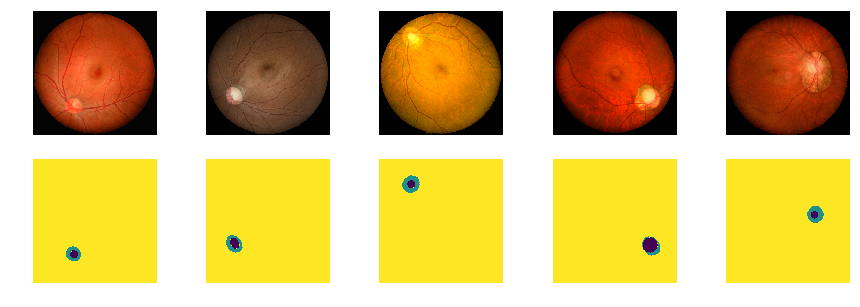

In [15]:
plt.figure(figsize=(15,5))

for i in range(5):
    fundus_img, label = train_dataset.__getitem__(i)
    plt.subplot(2,5,i+1)
    plt.imshow(fundus_img.transpose(1,2,0))
    plt.axis("off")

    plt.subplot(2,5,i+6)
    plt.imshow(label)
    plt.axis("off")


(3, 512, 512)
(512, 512)


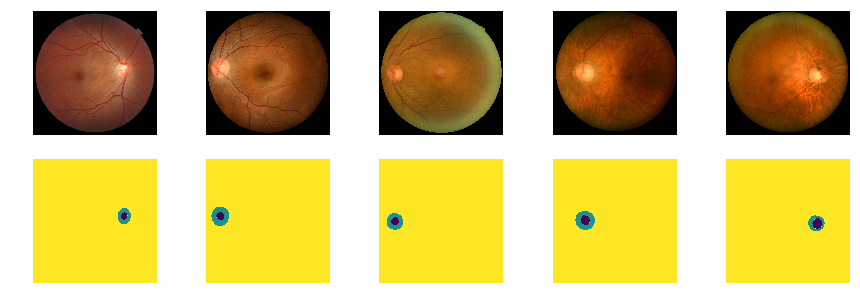

In [16]:
plt.figure(figsize=(15,5))

for i in range(5):
    fundus_img, label = val_dataset.__getitem__(i)
    plt.subplot(2,5,i+1)
    plt.imshow(fundus_img.transpose(1,2,0))
    plt.axis("off")

    plt.subplot(2,5,i+6)
    plt.imshow(label)
    plt.axis("off")

print(fundus_img.shape)
print(label.shape)

In [17]:
### Model code was used to generate Model instance, and Optimizer, loss function, 
### evaluation index and other information were defined for subsequent training.

# # UNet
# model = cup_disc_UNet(num_classes=3) # 1

# # GR-ConvNet, a.k.a GenerativeResNet
# from grconvnet3_paddle import GenerativeResnet
# model= GenerativeResnet(input_channels=3, output_channels=3, channel_size=32) # 

# GenerativeCoTNet
from gcotconvnet_paddle import GenerativeCoTNet
model = GenerativeCoTNet(input_channels=3, output_channels=3, channel_size=32)

# # BiSeNetV2
# from paddleseg.models import BiSeNetV2
# model = BiSeNetV2(num_classes=3,
#                  lambd=0.25,
#                  align_corners=False,
#                  pretrained=None)

model_info=paddle.summary(model,(1,3,512,512))  # (1,3,512,512) when image_size = 512
print(model_info)

### The SUMMARY interface provided by the paddlepaddle is called to visualize the constructed model, 
### which is convenient to view and confirm the model structure and parameter information.
# paddle.Model(model).summary((-1,3,256,256)) 

if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())


criterion = nn.CrossEntropyLoss(axis=1) # axis=0
# criterion = MinusDiceLoss()
# criterion = MinusDiceLoss2()
metric = DiceLoss2()

TypeError: reshape() takes from 2 to 3 positional arguments but 6 were given

In [ ]:
### training process Unet 256
train(model, iters, train_loader, val_loader, optimizer, criterion, metric, log_interval=32, evl_interval=160)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


[TRAIN] iter=32/40000 avg_loss=2.1592 avg_dice=0.3870
[TRAIN] iter=64/40000 avg_loss=0.2149 avg_dice=0.5161
[TRAIN] iter=96/40000 avg_loss=0.1239 avg_dice=0.5593
[TRAIN] iter=128/40000 avg_loss=0.0762 avg_dice=0.5884
[TRAIN] iter=160/40000 avg_loss=0.0695 avg_dice=0.5824
[EVAL] iter=160/40000 avg_loss=0.0436 dice=0.6789
[TRAIN] iter=192/40000 avg_loss=0.0626 avg_dice=0.5938
[TRAIN] iter=224/40000 avg_loss=0.0445 avg_dice=0.6442
[TRAIN] iter=256/40000 avg_loss=0.0453 avg_dice=0.6278
[TRAIN] iter=288/40000 avg_loss=0.0443 avg_dice=0.6237
[TRAIN] iter=320/40000 avg_loss=0.0390 avg_dice=0.6480
[EVAL] iter=320/40000 avg_loss=0.0321 dice=0.6468
[TRAIN] iter=352/40000 avg_loss=0.0415 avg_dice=0.6222
[TRAIN] iter=384/40000 avg_loss=0.0353 avg_dice=0.6550
[TRAIN] iter=416/40000 avg_loss=0.0340 avg_dice=0.6624
[TRAIN] iter=448/40000 avg_loss=0.0386 avg_dice=0.6420
[TRAIN] iter=480/40000 avg_loss=0.0312 avg_dice=0.6707
[EVAL] iter=480/40000 avg_loss=0.0229 dice=0.7069
[TRAIN] iter=512/40000 avg_l

ERROR:root:DataLoader reader thread raised an exception!
Exception in thread Thread-800:
Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py", line 462, in _get_data
    data = self._data_queue.get(timeout=self._timeout)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py", line 391, in _thread_loop
    batch = self._get_data()
  F

KeyboardInterrupt: 

In [ ]:
### training process GR-ConvNet 256
train(model, iters, train_loader, val_loader, optimizer, criterion, metric, log_interval=32, evl_interval=160)

[TRAIN] iter=32/40000 avg_loss=0.2267 avg_dice=0.4574
[TRAIN] iter=64/40000 avg_loss=0.0511 avg_dice=0.5821
[TRAIN] iter=96/40000 avg_loss=0.0377 avg_dice=0.6142
[TRAIN] iter=128/40000 avg_loss=0.0323 avg_dice=0.6541
[TRAIN] iter=160/40000 avg_loss=0.0297 avg_dice=0.6638
[EVAL] iter=160/40000 avg_loss=0.0301 dice=0.5549
[TRAIN] iter=192/40000 avg_loss=0.0278 avg_dice=0.6681
[TRAIN] iter=224/40000 avg_loss=0.0268 avg_dice=0.6762
[TRAIN] iter=256/40000 avg_loss=0.0266 avg_dice=0.6837
[TRAIN] iter=288/40000 avg_loss=0.0254 avg_dice=0.6838
[TRAIN] iter=320/40000 avg_loss=0.0237 avg_dice=0.6983
[EVAL] iter=320/40000 avg_loss=0.0147 dice=0.7813
[TRAIN] iter=352/40000 avg_loss=0.0244 avg_dice=0.6696
[TRAIN] iter=384/40000 avg_loss=0.0223 avg_dice=0.7163
[TRAIN] iter=416/40000 avg_loss=0.0225 avg_dice=0.7127
[TRAIN] iter=448/40000 avg_loss=0.0223 avg_dice=0.7188
[TRAIN] iter=480/40000 avg_loss=0.0216 avg_dice=0.7152
[EVAL] iter=480/40000 avg_loss=0.0141 dice=0.7567
[TRAIN] iter=512/40000 avg_l

ERROR:root:DataLoader reader thread raised an exception!
Exception in thread Thread-1147:
Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py", line 462, in _get_data
    data = self._data_queue.get(timeout=self._timeout)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py", line 391, in _thread_loop
    batch = self._get_data()
  

KeyboardInterrupt: 

Dice Loss  UNet
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
[TRAIN] iter=50/40000 avg_loss=0.3331 avg_dice=0.6669
[TRAIN] iter=100/40000 avg_loss=0.3286 avg_dice=0.6714
[TRAIN] iter=150/40000 avg_loss=0.3342 avg_dice=0.6658
[TRAIN] iter=200/40000 avg_loss=0.2753 avg_dice=0.7247
[TRAIN] iter=250/40000 avg_loss=0.3333 avg_dice=0.6667
[TRAIN] iter=300/40000 avg_loss=0.3297 avg_dice=0.6703
[TRAIN] iter=350/40000 avg_loss=0.3267 avg_dice=0.6733
[TRAIN] iter=400/40000 avg_loss=0.3212 avg_dice=0.6788
[TRAIN] iter=450/40000 avg_loss=0.2999 avg_dice=0.7001
[TRAIN] iter=500/40000 avg_loss=0.2627 avg_dice=0.7373
[EVAL] iter=500/40000 avg_loss=0.3786 dice=0.6214
[TRAIN] iter=550/40000 avg_loss=0.3111 avg_dice=0.6889
[TRAIN] iter=600/40000 avg_loss=0.3357 avg_dice=0.6643
[TRAIN] iter=650/40000 avg_loss=0.3349 avg_dice=0.6651
[TRAIN] iter=700/40000 avg_loss=0.3342 avg_dice=0.6658
[TRAIN] iter=750/40000 avg_loss=0.3337 avg_dice=0.6663
[TRAIN] iter=800/40000 avg_loss=0.3332 avg_dice=0.6668
[TRAIN] iter=850/40000 avg_loss=0.3328 avg_dice=0.6672
[TRAIN] iter=900/40000 avg_loss=0.3324 avg_dice=0.6676
[TRAIN] iter=950/40000 avg_loss=0.3319 avg_dice=0.6681
[TRAIN] iter=1000/40000 avg_loss=0.3316 avg_dice=0.6684
[EVAL] iter=1000/40000 avg_loss=0.3313 dice=0.6687
[TRAIN] iter=1050/40000 avg_loss=0.3311 avg_dice=0.6689
[TRAIN] iter=1100/40000 avg_loss=0.3305 avg_dice=0.6695
[TRAIN] iter=1150/40000 avg_loss=0.3295 avg_dice=0.6705
[TRAIN] iter=1200/40000 avg_loss=0.3279 avg_dice=0.6721
[TRAIN] iter=1250/40000 avg_loss=0.3258 avg_dice=0.6742
[TRAIN] iter=1300/40000 avg_loss=0.3224 avg_dice=0.6776
[TRAIN] iter=1350/40000 avg_loss=0.3142 avg_dice=0.6858
[TRAIN] iter=1400/40000 avg_loss=0.2965 avg_dice=0.7035
[TRAIN] iter=1450/40000 avg_loss=0.3313 avg_dice=0.6687
[TRAIN] iter=1500/40000 avg_loss=0.3303 avg_dice=0.6697
[EVAL] iter=1500/40000 avg_loss=0.3292 dice=0.6708
[TRAIN] iter=1550/40000 avg_loss=0.3289 avg_dice=0.6711
[TRAIN] iter=1600/40000 avg_loss=0.3265 avg_dice=0.6735
[TRAIN] iter=1650/40000 avg_loss=0.3176 avg_dice=0.6824
[TRAIN] iter=1700/40000 avg_loss=0.3383 avg_dice=0.6617
[TRAIN] iter=1750/40000 avg_loss=0.3371 avg_dice=0.6629
[TRAIN] iter=1800/40000 avg_loss=0.3353 avg_dice=0.6647
[TRAIN] iter=1850/40000 avg_loss=0.3336 avg_dice=0.6664
[TRAIN] iter=1900/40000 avg_loss=0.3323 avg_dice=0.6677
[TRAIN] iter=1950/40000 avg_loss=0.3311 avg_dice=0.6689
[TRAIN] iter=2000/40000 avg_loss=0.3301 avg_dice=0.6699
[EVAL] iter=2000/40000 avg_loss=0.3296 dice=0.6704
[TRAIN] iter=2050/40000 avg_loss=0.3288 avg_dice=0.6712
[TRAIN] iter=2100/40000 avg_loss=0.3274 avg_dice=0.6726
[TRAIN] iter=2150/40000 avg_loss=0.3260 avg_dice=0.6740
[TRAIN] iter=2200/40000 avg_loss=0.3241 avg_dice=0.6759
[TRAIN] iter=2250/40000 avg_loss=0.3219 avg_dice=0.6781
[TRAIN] iter=2300/40000 avg_loss=0.3185 avg_dice=0.6815
[TRAIN] iter=2350/40000 avg_loss=0.3146 avg_dice=0.6854
[TRAIN] iter=2400/40000 avg_loss=0.3056 avg_dice=0.6944
[TRAIN] iter=2450/40000 avg_loss=0.2889 avg_dice=0.7111
[TRAIN] iter=2500/40000 avg_loss=0.5245 avg_dice=0.4755
[EVAL] iter=2500/40000 avg_loss=0.3335 dice=0.6665
[TRAIN] iter=2550/40000 avg_loss=0.3335 avg_dice=0.6665
[TRAIN] iter=2600/40000 avg_loss=0.3332 avg_dice=0.6668
[TRAIN] iter=2650/40000 avg_loss=0.3330 avg_dice=0.6670
[TRAIN] iter=2700/40000 avg_loss=0.3327 avg_dice=0.6673
[TRAIN] iter=2750/40000 avg_loss=0.3325 avg_dice=0.6675
[TRAIN] iter=2800/40000 avg_loss=0.3322 avg_dice=0.6678
[TRAIN] iter=2850/40000 avg_loss=0.3320 avg_dice=0.6680
[TRAIN] iter=2900/40000 avg_loss=0.3318 avg_dice=0.6682
[TRAIN] iter=2950/40000 avg_loss=0.3315 avg_dice=0.6685
[TRAIN] iter=3000/40000 avg_loss=0.3312 avg_dice=0.6688
[EVAL] iter=3000/40000 avg_loss=0.3303 dice=0.6697
[TRAIN] iter=3050/40000 avg_loss=0.3310 avg_dice=0.6690
[TRAIN] iter=3100/40000 avg_loss=0.3306 avg_dice=0.6694
[TRAIN] iter=3150/40000 avg_loss=0.3304 avg_dice=0.6696
[TRAIN] iter=3200/40000 avg_loss=0.3300 avg_dice=0.6700
[TRAIN] iter=3250/40000 avg_loss=0.3294 avg_dice=0.6706

#思路一：baseline 的CELoss([1,3,256,256],[1,256,256])，  
#将label 拆为[1,3,256,256]  
#criterion = nn.CrossEntropyLoss(axis=0)  

---------------------------------------------------------------------------ValueError                                Traceback (most recent call last)<ipython-input-60-438509a22f4a> in <module>
      1 ### training process
----> 2 train(model, iters, train_loader, val_loader, optimizer, criterion, metric, log_interval=50, evl_interval=500)
<ipython-input-51-9ea3c548ddc4> in train(model, iters, train_dataloader, val_dataloader, optimizer, criterion, metric, log_interval, evl_interval)
     32             labels_one_hot = paddle.stack(tuple(single_label_lists), axis=1)  # label [1,3,256,256]
     33 
---> 34             loss = criterion(logits, labels_one_hot)  # gt_label
     35             # print('loss: ',loss)
     36             # Stop Adding
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py in __call__(self, *inputs, **kwargs)
    900                 self._built = True
    901 
--> 902             outputs = self.forward(*inputs, **kwargs)
    903 
    904             for forward_post_hook in self._forward_post_hooks.values():
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/loss.py in forward(self, input, label)
    403             axis=self.axis,
    404             use_softmax=self.use_softmax,
--> 405             name=self.name)
    406 
    407         return ret
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/functional/loss.py in cross_entropy(input, label, weight, ignore_index, reduction, soft_label, axis, use_softmax, name)
   1390             input, label, 'soft_label', soft_label, 'ignore_index',
   1391             ignore_index, 'numeric_stable_mode', True, 'axis', axis,
-> 1392             'use_softmax', use_softmax)
   1393 
   1394         if weight is not None:
ValueError: (InvalidArgument) If Attr(soft_label) == false, the axis dimension of Input(Label) should be 1.
  [Hint: Expected labels_dims[axis] == 1UL, but received labels_dims[axis]:8 != 1UL:1.] (at /paddle/paddle/fluid/operators/softmax_with_cross_entropy_op.cc:179)
  [operator < softmax_with_cross_entropy > error]

### Experiment Record  
iter = 20000  
1st Training: Unet 0.1791  
2nd Training: GR-ConvNet **0.1873**    
3rd Training：GR-ConvNet 0.1879  
3rd Training: UNet + Data Augmentation **0.1916**  
~~4th Training：UNet + number_class =1 error 1.3282  ~~
~~5th Training: UNet + Dice Loss 0.6708 (1500 iters)  ~~
5th Incremetal Training: UNet + Dice Loss + Adam 0.7221  
6th Training: GR-ConvNet + Dice Loss 0.8253 (3400 iters)  
6th Incremetal Training: GR-ConvNet + Dice Loss + Adam 0.9538  
6th Incremetal Training: GR-ConvNet + Dice Loss + SGD 0.9695   

**CE Loss + Dice Metric (Marco's Version)**  
7th Training: GR-ConvNet 256 **0.9259** (6700 iters) **0.9256** (5600 iters)  
7th Incremental Training: GR-ConvNet 256 **0.9276** (1760 iters)  
7th Incremental Training: GR-ConvNet **image_size=512 0.9320** (3360 iters)
8th Training: UNet 256 0.9018 (4000 iters)  




### Incremental Training

In [ ]:
# # UNet
# model = cup_disc_UNet(num_classes=3) 

# GR-ConvNet
from grconvnet3_paddle import GenerativeResnet
model= GenerativeResnet(input_channels=3, output_channels=3, channel_size=32) # 

optimizer_type = 'sgd'
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(1e-3, parameters=model.parameters())
elif optimizer_type == 'sgd':
    optimizer = paddle.optimizer.SGD(learning_rate=1e-4, parameters=model.parameters(), 
                                     weight_decay=None) # , grad_clip=None, name=None
else:
    print("No such optimzier, please add it by yourself")
    
criterion = nn.CrossEntropyLoss(axis=1)
metric = DiceLoss2()

para_state_dict = paddle.load("trained_models/best_model_0.9320/model.pdparams")
# opt_state_dict = paddle.load("trained_models/best_model_0.9276/optimizer.pdopt")

model.set_state_dict(para_state_dict)
# optimizer.set_state_dict(opt_state_dict)

train(model, iters, train_loader, val_loader, optimizer, criterion, metric, log_interval=32, evl_interval=160)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


### Evaluation

[1, 3, 256, 256]
[1, 256, 256]
[256, 256]
Tensor(shape=[1, 256, 256], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [[[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         ...,
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]]])
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice.


(nan, nan)

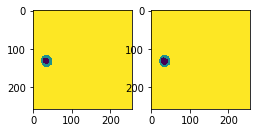

In [ ]:
import numpy as np

def val_e(model, val_dataloader):
    model.eval()
    avg_loss_list = []
    avg_dice_list = []
    with paddle.no_grad():
        for data in val_dataloader:
            fundus_img =paddle.to_tensor((data[0] / 255.).astype("float32")) # [1, 3, 256, 256]
            gt_label = (data[1]).astype("int64")  # [1, 256, 256]
            print(fundus_img.shape)
            print(gt_label.shape)
            # print(gt_label)
            plt.subplot(2,3,1)
            print(gt_label[0].shape)
            plt.imshow(gt_label[0])

            pred = model(fundus_img)
            pred_img = pred.argmax(1)
            print(pred_img)
            pred_img = pred_img.numpy()
            pred_gray = np.squeeze(pred_img, axis=0)
            pred_gray = pred_gray.astype('float32')
            # print(pred.shape)
            # print(pred[0].shape)
            print(pred_gray)
            plt.subplot(2,3,2)
            plt.imshow(pred_gray)
            
            # # For the outputs of Baseline
            # re= paddle.transpose(pred[0], perm=[1, 2, 0])
            # plt.imshow(re)   # visualizing the predicted results 
            
            # For the outputs of Dice Loss Function (MinusDiceLoss3) 
            # re1 = np.array(pred[0][0])
            # re2 = np.array(pred[0][1])
            # re3 = np.array(pred[0][2])
            # re = re1 + re2 + re3
            # print(re)
            # plt.imshow(re)
            # plt.subplot(2,3,4)
            # plt.imshow(re1)
            # plt.subplot(2,3,5)
            # plt.imshow(re2)
            # plt.subplot(2,3,6)
            # plt.imshow(re3)


            # loss = criterion(pred, gt_label)
            # dice = metric(pred, gt_label)  

            # avg_loss_list.append(loss.numpy()[0])
            # avg_dice_list.append(dice.numpy()[0])

    avg_loss = np.array(avg_loss_list).mean()
    avg_dice = np.array(avg_dice_list).mean()

    return avg_loss, avg_dice

val_filelists=['0016'] # , '0052', '0001', '0026', '0022', '0096', '0043', '0064', '0059', '0060'
img_val_transforms = trans.Compose([

])

val_dataset = FundusDataset(image_file = images_file, 
                        fundus_transforms = img_val_transforms,
                        gt_path = gt_file,
                        filelists=val_filelists)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)


best_model_path = "trained_models/best_model_0.9259/model.pdparams"  # 0.9538
# model = cup_disc_UNet(num_classes = 3)
from grconvnet3_paddle import GenerativeResnet
model= GenerativeResnet(input_channels=3, output_channels=3, channel_size=32)
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)

val_e(model,val_loader)

### Inference

In [ ]:
!unzip -o /home/aistudio/data/data103109/val_data.zip  -d /home/aistudio/val_data

In [ ]:
### inference(testing) process, load the model parameters

best_model_path = "trained_models/best_model_0.9320/model.pdparams"
# model = cup_disc_UNet(num_classes = 3)
from grconvnet3_paddle import GenerativeResnet
model= GenerativeResnet(input_channels=3, output_channels=3, channel_size=32) 
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)
model.eval()
### gerenate the test Dataset
test_path = 'val_data/multi-modality_images'  # the path to the training data

test_filelists = os.listdir(test_path)
test_filelists.sort()
print(test_filelists)

### gerenate the test Dataset
test_dataset = FundusDataset(image_file = test_path, 
                            fundus_transforms = None,
                            mode='test')  # , filelists=['0101','0112']

['0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125', '0126', '0127', '0128', '0129', '0130', '0131', '0132', '0133', '0134', '0135', '0136', '0137', '0138', '0139', '0140', '0141', '0142', '0143', '0144', '0145', '0146', '0147', '0148', '0149', '0150', '0151', '0152', '0153', '0154', '0155', '0156', '0157', '0158', '0159', '0160', '0161', '0162', '0163', '0164', '0165', '0166', '0167', '0168', '0169', '0170', '0171', '0172', '0173', '0174', '0175', '0176', '0177', '0178', '0179', '0180', '0181', '0182', '0183', '0184', '0185', '0186', '0187', '0188', '0189', '0190', '0191', '0192', '0193', '0194', '0195', '0196', '0197', '0198', '0199', '0200']


In [ ]:
### The fundus images in the test dataset are segmented one by one
### The segmentation results are resized and stored as BMP images

for fundus_img, idx, h, w in test_dataset:
    # print(idx)
    fundus_img = fundus_img[np.newaxis, ...]
    fundus_img = paddle.to_tensor((fundus_img / 255.).astype("float32"))
    logits = model(fundus_img)
    pred_img = logits.numpy().argmax(1)
    pred_gray = np.squeeze(pred_img, axis=0)
    pred_gray = pred_gray.astype('float32')
    # print(pred_gray.shape)
    pred_gray[pred_gray == 1] = 128
    pred_gray[pred_gray == 2] = 255
    # print(pred_gray)
    # pred_ = cv2.resize(pred_gray, (w, h)) # baseline resize
    
    # Marco's resize to original shape
    min_side =  min(h,w)
    pred_ = cv2.resize(pred_gray, (min_side, min_side))
    padding = int((max(h,w) -min(h,w))/2)
    # print(padding)
    transform = trans.Pad((padding,0), fill = 255) #pad pixel=255 in left-right side
    pred_ = transform(pred_)

    # Visualization 
    # print(pred_.shape)
    cv2.imwrite('Disc_Cup_Segmentations/'+idx+'.bmp', pred_)